In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('data/movies/ratings.csv')
dataset.columns = ['user_id', 'item_id', 'rating', 'timestamp']

In [3]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(671, 9066)

In [4]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values
dataset.head()

,user_id,item_id,rating,timestamp
0,0,30,2.5,1260759144
1,0,833,3.0,1260759179
2,0,859,3.0,1260759182
3,0,906,2.0,1260759185
4,0,931,4.0,1260759205


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

In [6]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

Using TensorFlow backend.


In [7]:
# Matrix factorisation model
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
model_mf = keras.Model([user_input, movie_input], prod)
model_mf.compile('adam', 'mean_squared_error')
model_mf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         27201       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2016        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [8]:
history_mf = model_mf.fit([train.user_id, train.item_id], train.rating, epochs=15)

Epoch 1/15
80003/80003 [==============================] - 3s 42us/step - loss: 12.8477
Epoch 2/15
80003/80003 [==============================] - 3s 38us/step - loss: 7.1246
Epoch 3/15
80003/80003 [==============================] - 3s 40us/step - loss: 3.7387
Epoch 4/15
80003/80003 [==============================] - 4s 49us/step - loss: 2.4691
Epoch 5/15
80003/80003 [==============================] - 4s 45us/step - loss: 1.8317
Epoch 6/15
80003/80003 [==============================] - 3s 42us/step - loss: 1.4746
Epoch 7/15
80003/80003 [==============================] - 4s 44us/step - loss: 1.2562
Epoch 8/15
80003/80003 [==============================] - 3s 44us/step - loss: 1.1136
Epoch 9/15
80003/80003 [==============================] - 4s 46us/step - loss: 1.0161
Epoch 10/15
80003/80003 [==============================] - 4s 48us/step - loss: 0.9460
Epoch 11/15
80003/80003 [==============================] - 4s 47us/step - loss: 0.8941
Epoch 12/15
80003/80003 [==========================

Text(0,0.5,'Train Error')

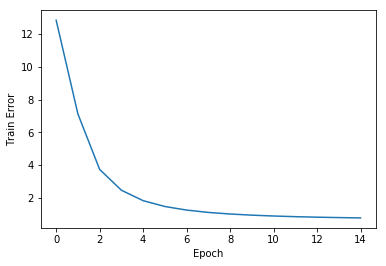

In [9]:
pd.Series(history_mf.history['loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [10]:
# Neural networks model

n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(128,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(64,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(32,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(16,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model_nn = keras.Model([user_input, movie_input], result)
model_nn.compile(optimizer=adam,loss= 'mean_absolute_error')
model_nn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         72536       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         3360        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [11]:
history_nn = model_nn.fit([train.user_id, train.item_id], train.rating, epochs=15)

Epoch 1/15
80003/80003 [==============================] - 7s 93us/step - loss: 0.7562
Epoch 2/15
80003/80003 [==============================] - 6s 80us/step - loss: 0.6946
Epoch 3/15
80003/80003 [==============================] - 6s 71us/step - loss: 0.6743
Epoch 4/15
80003/80003 [==============================] - 6s 76us/step - loss: 0.6617
Epoch 5/15
80003/80003 [==============================] - 7s 82us/step - loss: 0.6540
Epoch 6/15
80003/80003 [==============================] - 7s 91us/step - loss: 0.6478
Epoch 7/15
80003/80003 [==============================] - 7s 91us/step - loss: 0.6444
Epoch 8/15
80003/80003 [==============================] - 7s 91us/step - loss: 0.6392
Epoch 9/15
80003/80003 [==============================] - 7s 91us/step - loss: 0.6342
Epoch 10/15
80003/80003 [==============================] - 7s 91us/step - loss: 0.6310
Epoch 11/15
80003/80003 [==============================] - 7s 91us/step - loss: 0.6280
Epoch 12/15
80003/80003 [===========================

Text(0,0.5,'Train Error')

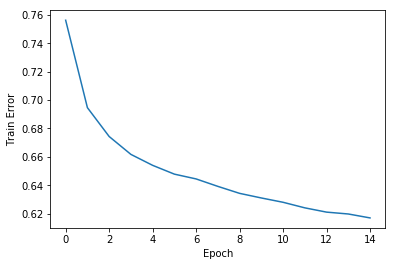

In [12]:
pd.Series(history_nn.history['loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [13]:
from sklearn.metrics import mean_absolute_error

def round_of_rating(number):
        return np.round(number * 2) / 2
    
y_pred_mf = np.array(list(map(round_of_rating, model_mf.predict([test.user_id, test.item_id]))))
y_pred_nn = np.array(list(map(round_of_rating, model_nn.predict([test.user_id, test.item_id]))))
y_true = test.rating

mse_mf = mean_absolute_error(y_true, y_pred_mf)
mse_nn = mean_absolute_error(y_true, y_pred_nn)
print('Matrix factorisation MSE:', np.round(mse_mf,5))
print('Neural networks MSE:', np.round(mse_nn, 5))

Matrix factorisation MSE: 0.77641
Neural networks MSE: 0.65739
